<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter5/src/opt_constraint_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 条件ベースアプローチを用いた有望な実験候補の探索を行う
### 使用するデータセットの参考文献
 - Tamura, R. et al. Materials informatics approach to understand aluminum alloys. Sci Technol Adv Mater 540–551 (2020) doi:10.1080/14686996.2020.1791676

## データセットのダウンロード
 - https://www.tandfonline.com/doi/full/10.1080/14686996.2020.1791676#supplemental-material-section からtsta_a_1791676_sm7407.csvをダウンロード

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、tsta_a_1791676_sm7407.csvをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

## ライブラリをインポート

In [3]:
! pip install optuna==3.6.1
! pip install lightgbm==4.2.0
! pip install scikit-learn==1.3.2 #ライブラリのverによっては次元圧縮の挙動が異なることがあるため注意
! pip install numpy==1.26.4
! pip install pandas==2.2.2
! pip install umap-learn==0.5.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 39.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.3 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any

In [4]:
import warnings

warnings.filterwarnings("ignore")

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import umap
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## グラフ表示の際のフォントサイズを設定

In [5]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20

## データを読み込み、データフレームに格納

In [6]:
data = pd.read_csv(INPUT_FILE_PATH  + "tsta_a_1791676_sm7407.csv")
data

,ID,X,n,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),2% proof stress (Mpa),Tensile strength (Mpa),Elongation (%)
0,A 5005 P,1,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,95,125,2
1,A 5005 P,1,4,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,120,145,2
2,A 5005 P,1,6,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,145,165,2
3,A 5005 P,1,8,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,165,185,2
4,A 5005 P,2,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,85,120,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,A 5N01 P,1,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,115,125,3
111,A 5N01 P,1,6,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,135,145,2
112,A 5N01 P,3,2,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,85,120,4
113,A 5N01 P,3,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,105,140,3


In [7]:
data = data.rename(columns={'2% proof stress (Mpa)': '2% proof stress (MPa)', 'Tensile strength (Mpa)': 'Tensile strength (MPa)'})
data

,ID,X,n,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),2% proof stress (MPa),Tensile strength (MPa),Elongation (%)
0,A 5005 P,1,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,95,125,2
1,A 5005 P,1,4,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,120,145,2
2,A 5005 P,1,6,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,145,165,2
3,A 5005 P,1,8,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,165,185,2
4,A 5005 P,2,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,85,120,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,A 5N01 P,1,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,115,125,3
111,A 5N01 P,1,6,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,135,145,2
112,A 5N01 P,3,2,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,85,120,4
113,A 5N01 P,3,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,105,140,3


## データの材料特性間の相関を確認

In [8]:
correlation = data[
    ["2% proof stress (MPa)", "Tensile strength (MPa)", "Elongation (%)"]
].corr()
correlation

,2% proof stress (MPa),Tensile strength (MPa),Elongation (%)
2% proof stress (MPa),1.000000,0.906414,-0.390692
Tensile strength (MPa),0.906414,1.000000,-0.081633
Elongation (%),-0.390692,-0.081633,1.000000


## 回帰モデルを構築

In [9]:
params_elongation = {
    "objective": "regression",
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state": 42,
    "max_depth": 5,
    "n_estimators": 1000,
    "colsample_bytree": 0.7,
    "min_data_in_leaf": 5,  # ハイパーパラメータチューニングで探索した値を調整
}

In [10]:
params_proof_stress = {
    "objective": "regression",
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state": 42,
    "max_depth": 5,
    "n_estimators": 1000,
    "colsample_bytree": 0.7,
}

In [11]:
# 説明変数と目的変数
wt_columns = [col for col in data.columns if "(wt%)" in col]
additional_features = ["X", "n"]
all_features = wt_columns + additional_features
X = data[all_features]
y_elongation = data["Elongation (%)"]
y_proof_stress = data["2% proof stress (MPa)"]

# トレーニングとテストデータに分割
X_train, X_test, y_train_elongation, y_test_elongation = train_test_split(
    X, y_elongation, test_size=0.2, random_state=42
)
_, _, y_train_proof_stress, y_test_proof_stress = train_test_split(
    X, y_proof_stress, test_size=0.2, random_state=42
)

# 学習データ用LightGBMモデルのトレーニング
model_elongation = lgb.LGBMRegressor(**params_elongation, verbose=-1)
model_proof_stress = lgb.LGBMRegressor(**params_proof_stress, verbose=-1)

model_elongation.fit(X_train, y_train_elongation)
model_proof_stress.fit(X_train, y_train_proof_stress)

# テストデータでの予測値
y_pred_elongation = model_elongation.predict(X_test)
y_pred_proof_stress = model_proof_stress.predict(X_test)

In [12]:
# 指標計算関数
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae


# Elongation (%) の評価指標
r2_elongation, rmse_elongation, mae_elongation = calculate_metrics(
    y_test_elongation, y_pred_elongation
)

# 2% proof stress (Mpa) の評価指標
r2_proof_stress, rmse_proof_stress, mae_proof_stress = calculate_metrics(
    y_test_proof_stress, y_pred_proof_stress
)

Text(0.5, 1.0, 'Elongation (%) - Prediction vs Actual\n')

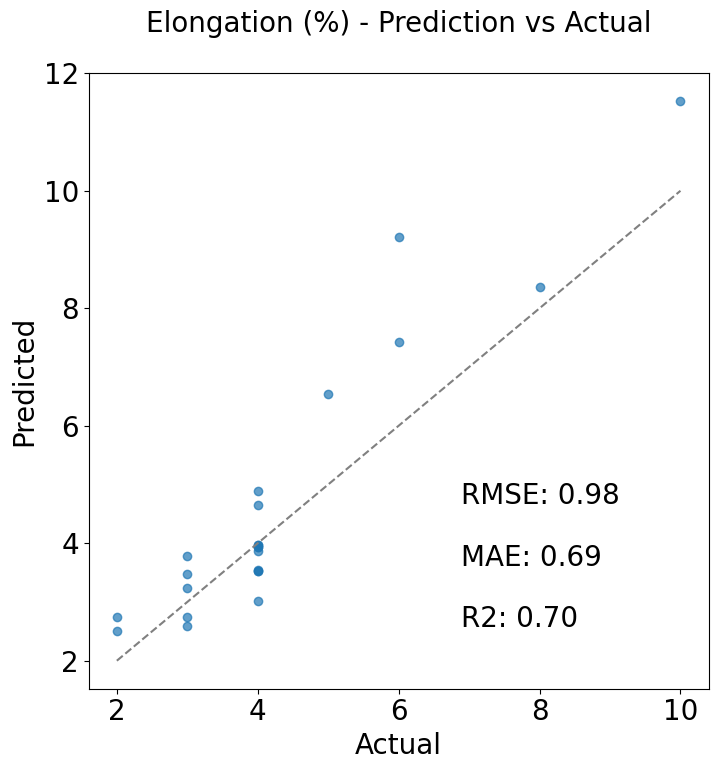

In [13]:
## Elongation (%) のプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_test_elongation, y_pred_elongation, alpha=0.7)
plt.plot(
    [y_test_elongation.min(), y_test_elongation.max()],
    [y_test_elongation.min(), y_test_elongation.max()],
    "--",
    color="gray",
    label="truth",
)
plt.text(0.6, 0.3, f"RMSE: {rmse_elongation:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.2, f"MAE: {mae_elongation:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.1, f"R2: {r2_elongation:.2f}", transform=plt.gca().transAxes)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Elongation (%) - Prediction vs Actual\n")

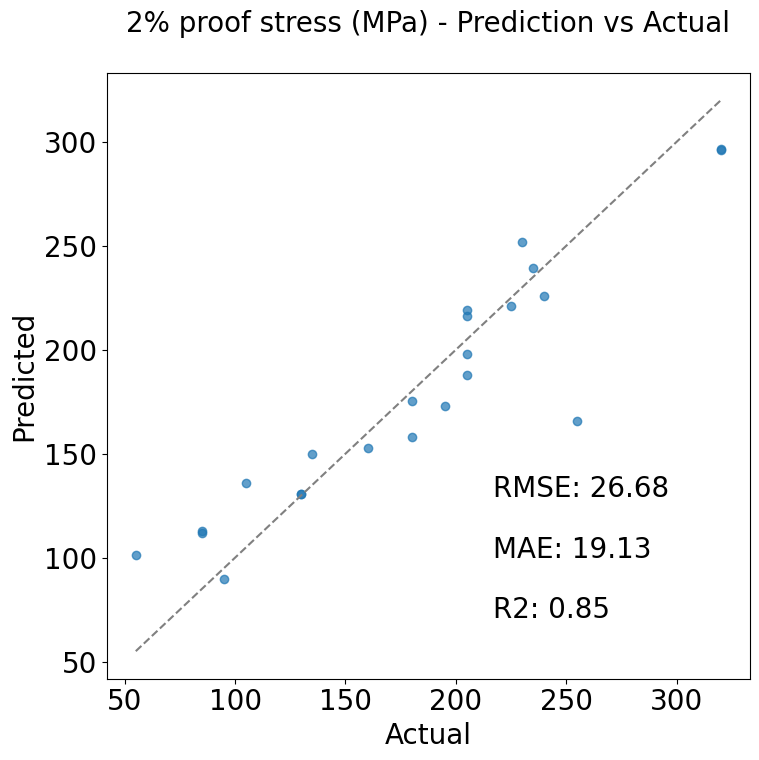

In [14]:
# 2% proof stress (MPa) のプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_test_proof_stress, y_pred_proof_stress, alpha=0.7)
plt.plot(
    [y_test_proof_stress.min(), y_test_proof_stress.max()],
    [y_test_proof_stress.min(), y_test_proof_stress.max()],
    "--",
    color="gray",
    label="truth",
)

plt.text(0.6, 0.3, f"RMSE: {rmse_proof_stress:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.2, f"MAE: {mae_proof_stress:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.1, f"R2: {r2_proof_stress:.2f}", transform=plt.gca().transAxes)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"2% proof stress (MPa) - Prediction vs Actual\n")

plt.tight_layout()
plt.show()

## 全データ学習のモデルを構築

In [15]:
# Optuna内で使用する全データ学習モデル
model_full_elongation = lgb.LGBMRegressor(**params_elongation, verbose=-1)
model_full_proof_stress = lgb.LGBMRegressor(**params_proof_stress, verbose=-1)

model_full_elongation.fit(X, y_elongation)
model_full_proof_stress.fit(X, y_proof_stress)

# データ全体での目的変数の範囲を取得
elongation_min, elongation_max = y_elongation.min(), y_elongation.max()
proof_stress_min, proof_stress_max = y_proof_stress.min(), y_proof_stress.max()

## 条件ベースアプローチを用いた有望な実験候補の探索を行う

In [16]:
# 試行結果を記録するためのリスト
trial_results_multi = []


def objective_multi(trial):
    # wt%列の試行値をサンプリング
    proportions = {
        col: trial.suggest_float(col, X[col].min(), X[col].max()) for col in wt_columns
    }
    # 合計が100になるよう正規化
    total = sum(proportions.values())
    normalized_proportions = {
        col: (value / total) * 100 for col, value in proportions.items()
    }

    # normalized_proportionsを小数点2桁に
    normalized_proportions = {
        col: round(value, 2) for col, value in normalized_proportions.items()
    }

    # Xとnの試行値を整数型でサンプリング
    additional_values = {
        "X": trial.suggest_int("X", int(X["X"].min()), int(X["X"].max())),
        "n": trial.suggest_int("n", int(X["n"].min()), int(X["n"].max())),
    }

    # サンプルデータ作成
    input_data = pd.DataFrame([{**normalized_proportions, **additional_values}])

    # 予測値の計算（全データ学習モデルを使用）
    pred_elongation = model_full_elongation.predict(input_data)[0]
    pred_proof_stress = model_full_proof_stress.predict(input_data)[0]

    # 制約条件の計算
    constraint_elongation = pred_elongation - 14  # 伸び率 >= 14 を制約とする
    constraint_proof_stress = pred_proof_stress - 180  # 耐力 >= 180 を制約とする

    # 制約条件を試行属性に記録
    trial.set_user_attr("constraints", [constraint_elongation, constraint_proof_stress])

    # 試行結果を記録
    trial_results_multi.append(
        {
            **normalized_proportions,
            **additional_values,
            "Predicted Elongation (%)": pred_elongation,
            "Predicted 2% proof stress (MPa)": pred_proof_stress,
        }
    )

    return pred_elongation, pred_proof_stress


# Optunaで多目的最適化
sampler_multi = optuna.samplers.TPESampler(
    seed=42, constraints_func=lambda trial: trial.user_attrs["constraints"]
)
study_multi = optuna.create_study(
    directions=["maximize", "maximize"], sampler=sampler_multi
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_multi.optimize(objective_multi, n_trials=100)

[I 2025-02-03 01:33:41,158] A new study created in memory with name: no-name-33e41dd5-6177-48b2-9806-10ac9c7fde85


In [17]:
optuna.visualization.plot_pareto_front(
    study=study_multi,
    target_names=["Predicted Elongation (%)", "Predicted 2% proof stress (MPa)"],
)

In [29]:
# 可視化結果を保存
fig = optuna.visualization.plot_pareto_front(
    study=study_multi,
    target_names=["Predicted Elongation (%)", "Predicted 2% proof stress (MPa)"],
)
fig.write_html('plot_pareto_front_all.html')

In [30]:
# plot_pareto_front_all.htmlをダウンロード
from google.colab import files

files.download('plot_pareto_front_all.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
optuna.visualization.plot_pareto_front(
    study=study_multi,
    target_names=["Predicted Elongation (%)", "Predicted 2% proof stress (MPa)"],
    include_dominated_trials=False,
)

In [31]:
# 可視化結果を保存
fig = optuna.visualization.plot_pareto_front(
    study=study_multi,
    target_names=["Predicted Elongation (%)", "Predicted 2% proof stress (MPa)"],
    include_dominated_trials=False,
)
fig.write_html('plot_pareto_front_sel.html')

In [32]:
files.download('plot_pareto_front_sel.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
results_multi_df = pd.DataFrame(trial_results_multi)
results_multi_df

,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (MPa)
0,0.21,0.72,0.19,97.42,1.13,0.02,0.02,0.22,0.08,3,1,11.303995,101.956717
1,0.35,0.64,0.11,97.36,1.28,0.03,0.06,0.11,0.05,3,2,3.878234,108.513152
2,0.19,0.28,0.15,97.84,1.32,0.05,0.07,0.01,0.08,1,1,12.081832,80.526989
3,0.35,0.74,0.21,97.61,0.87,0.07,0.06,0.03,0.07,1,9,2.806151,186.851430
4,0.19,0.50,0.13,95.86,2.91,0.02,0.10,0.19,0.12,4,6,3.569465,217.031529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.17,0.15,0.19,97.61,1.37,0.05,0.08,0.26,0.12,4,1,11.652382,108.601806
96,0.30,0.22,0.14,95.89,3.09,0.04,0.06,0.24,0.02,2,1,11.785762,132.484806
97,0.31,0.30,0.23,97.75,0.95,0.04,0.05,0.25,0.13,1,1,11.361018,90.223700
98,0.29,0.21,0.14,98.35,0.72,0.08,0.04,0.07,0.10,2,1,11.656480,107.086950


In [20]:
# 正規化（0～1）
norm_elongation_multi = (
    results_multi_df["Predicted Elongation (%)"] - elongation_min
) / (elongation_max - elongation_min)
norm_proof_stress_multi = (
    results_multi_df["Predicted 2% proof stress (MPa)"] - proof_stress_min
) / (proof_stress_max - proof_stress_min)

# スコアの計算（正規化後の加重和）
score_multi = 0.5 * norm_elongation_multi + 0.5 * norm_proof_stress_multi
print(score_multi)

0     0.380037
1     0.172380
2     0.367784
3     0.269272
4     0.341198
        ...   
95    0.401177
96    0.444253
97    0.362480
98    0.398814
99    0.382574
Length: 100, dtype: float64


In [21]:
results_multi_df["Score"] = score_multi
results_multi_df

,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (MPa),Score
0,0.21,0.72,0.19,97.42,1.13,0.02,0.02,0.22,0.08,3,1,11.303995,101.956717,0.380037
1,0.35,0.64,0.11,97.36,1.28,0.03,0.06,0.11,0.05,3,2,3.878234,108.513152,0.172380
2,0.19,0.28,0.15,97.84,1.32,0.05,0.07,0.01,0.08,1,1,12.081832,80.526989,0.367784
3,0.35,0.74,0.21,97.61,0.87,0.07,0.06,0.03,0.07,1,9,2.806151,186.851430,0.269272
4,0.19,0.50,0.13,95.86,2.91,0.02,0.10,0.19,0.12,4,6,3.569465,217.031529,0.341198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.17,0.15,0.19,97.61,1.37,0.05,0.08,0.26,0.12,4,1,11.652382,108.601806,0.401177
96,0.30,0.22,0.14,95.89,3.09,0.04,0.06,0.24,0.02,2,1,11.785762,132.484806,0.444253
97,0.31,0.30,0.23,97.75,0.95,0.04,0.05,0.25,0.13,1,1,11.361018,90.223700,0.362480
98,0.29,0.21,0.14,98.35,0.72,0.08,0.04,0.07,0.10,2,1,11.656480,107.086950,0.398814


In [22]:
# Scoreの高い順にソート
results_multi_df.sort_values("Score", ascending=False, inplace=True)
results_multi_df

,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (MPa),Score
8,0.32,0.35,0.10,95.08,3.83,0.05,0.08,0.12,0.07,2,1,14.728790,198.663217,0.639301
79,0.32,0.37,0.08,95.11,3.74,0.05,0.03,0.22,0.06,4,1,14.676639,194.505457,0.630952
92,0.33,0.26,0.09,95.11,3.85,0.04,0.04,0.24,0.04,3,1,14.500107,195.482354,0.627361
70,0.35,0.26,0.09,95.31,3.56,0.04,0.03,0.24,0.13,3,1,14.498656,194.544156,0.625780
94,0.32,0.65,0.21,95.07,3.48,0.05,0.07,0.09,0.04,3,1,14.104626,199.434418,0.622208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,0.35,0.05,0.14,97.47,1.73,0.01,0.08,0.15,0.02,1,4,2.395803,138.106140,0.177293
1,0.35,0.64,0.11,97.36,1.28,0.03,0.06,0.11,0.05,3,2,3.878234,108.513152,0.172380
34,0.19,0.08,0.16,96.42,2.87,0.08,0.07,0.03,0.10,1,3,3.759320,104.843953,0.162868
52,0.29,0.09,0.17,96.43,2.56,0.10,0.04,0.24,0.08,1,2,3.338372,108.377048,0.156279


In [23]:
# results_multi_dfの中でび率 >= 14 かつ耐力 >= 180 のデータを抽出
results_multi_df_sel = results_multi_df[
    (results_multi_df["Predicted Elongation (%)"] >= 14)
    & (results_multi_df["Predicted 2% proof stress (MPa)"] >= 180)
]
results_multi_df_sel

,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),X,n,Predicted Elongation (%),Predicted 2% proof stress (MPa),Score
8,0.32,0.35,0.10,95.08,3.83,0.05,0.08,0.12,0.07,2,1,14.728790,198.663217,0.639301
79,0.32,0.37,0.08,95.11,3.74,0.05,0.03,0.22,0.06,4,1,14.676639,194.505457,0.630952
92,0.33,0.26,0.09,95.11,3.85,0.04,0.04,0.24,0.04,3,1,14.500107,195.482354,0.627361
70,0.35,0.26,0.09,95.31,3.56,0.04,0.03,0.24,0.13,3,1,14.498656,194.544156,0.625780
94,0.32,0.65,0.21,95.07,3.48,0.05,0.07,0.09,0.04,3,1,14.104626,199.434418,0.622208
93,0.21,0.27,0.16,94.82,4.04,0.09,0.05,0.25,0.11,3,1,14.540675,187.982130,0.616259


## 探索で得られた有望な実験条件候補の素性を確認

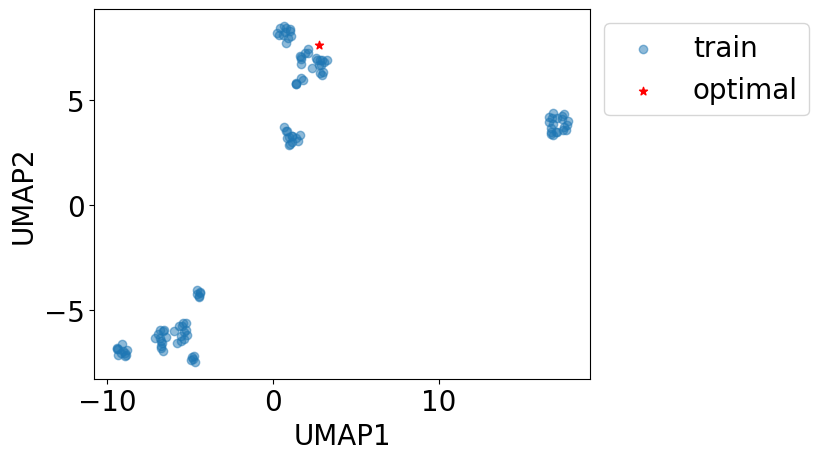

In [24]:
# 説明変数のスケーリングのため、スケーラーを定義
scaler_x = StandardScaler()
# スケーラーをfit
scaler_x.fit(X)
# 学習データにスケーラーを適用
X_train = scaler_x.transform(X)

# UMAPを定義
umap_ = umap.UMAP(
    n_components=2, random_state=42, n_neighbors=10
)  # n_neighborsのデフォルト値は15

# 学習データにUMAPを適用
result_umap = umap_.fit(X_train)
X_train_umap = result_umap.transform(X_train)
train_umap_df = pd.DataFrame(X_train_umap, columns=["UMAP1", "UMAP2"])

# テストデータにスケーラーを適用
X_test_multi = scaler_x.transform(results_multi_df_sel[all_features][:1])
# テストデータにUMAPを適用
X_test_umap_multi = result_umap.transform(X_test_multi)
test_umap_multi_df = pd.DataFrame(X_test_umap_multi, columns=["UMAP1", "UMAP2"])

# 結果をUMAPの主2次元空間に描画
plt.scatter(train_umap_df["UMAP1"], train_umap_df["UMAP2"], alpha=0.5)
plt.scatter(
    test_umap_multi_df["UMAP1"], test_umap_multi_df["UMAP2"], marker="*", color="red"
)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(["train", "optimal", "multi-obtimal"], bbox_to_anchor=(1, 1))
plt.show()

## 実行環境のライブラリverを保存

In [25]:
# Pythonのverを確認
!python3 -V

Python 3.11.11


In [26]:
!pip freeze > requirements_opt_constraint_demo.txt

In [27]:
files.download('requirements_opt_constraint_demo.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>